In [2]:
!pip install -U pymgrid

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.7/8.7 MB 9.6 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 31.6 MB/s eta 0:00:00
  Created wheel for pymgrid: filename=pymgrid-1.2.2-py3-none-any.whl size=3492847 sha256=94f44c35e07bab32255379f99aedbfe482f3b46c5dbcdd6b24a16b5a5abc6281
  Stored in directory: /root/.cache/pip/wheels/aa/9c/34/d880763dcc693c67448303756a6e1adb899bdc0d5080643030
Successfully built pymgrid


In [3]:
!pip install stable_baselines3

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 184.5/184.5 kB 6.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 85.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 65.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 40.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 6.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 10.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 6.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 69.9 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalli

In [4]:
import numpy as np
import pandas as pd
from gymnasium import Env
from gymnasium.spaces import Box, Discrete
from pymgrid import Microgrid
from pymgrid.modules import BatteryModule, LoadModule, RenewableModule, GridModule
from stable_baselines3 import DQN
from stable_baselines3.common.env_checker import check_env

In [8]:
load_df = pd.read_csv("/content/PUB_Demand_2024_v395.csv", skiprows=3)
load_data = np.array(load_df['Ontario Demand'])
load_data=load_data/16000
price_df = pd.read_csv('/content/PUB_PriceHOEPPredispOR_2024.csv', skiprows=3)
price_data=np.array(price_df["HOEP"])

In [9]:
hours_per_day = 24
days_per_year = 365
total_hours = hours_per_day * days_per_year  # 8760 hours in a year

# Simulate hourly solar generation
# Assumptions:
# - Peak output of 1 kW at noon on a clear day
# - Sinusoidal daily pattern, adjusted for seasonal variation
hours = np.arange(total_hours)
daily_cycle = np.sin(np.pi * (hours % 24) / 12)  # Peaks at noon (hour 12), zero at night
seasonal_cycle = 0.7 + 0.3 * np.sin(2 * np.pi * (hours / total_hours))  # Summer peak, winter dip

# Solar generation in kWh (assuming 1-hour intervals)
# Base output = 1 kW * daily pattern * seasonal variation * random weather noise
solar_generation = 1.0 * daily_cycle * seasonal_cycle * np.random.uniform(0.8, 1.0, total_hours)

# Ensure no negative values (nighttime should be 0)
solar_generation = np.clip(solar_generation, 0, None)

solar_generation = np.concat([np.zeros(6), solar_generation, solar_generation[-24:]])
solar_generation=solar_generation[:-6]


In [10]:
price_data=price_data[:100]
load_data=load_data[:100]
solar_generation=solar_generation[:100]

In [20]:
# Assuming load_data, solar_generation, and price_data are defined elsewhere (e.g., 8784-hour arrays)
# Microgrid setup
battery = BatteryModule(min_capacity=0,
                        max_capacity=100,
                        max_charge=50,
                        max_discharge=50,
                        efficiency=1.0,
                        init_soc=0.5)
load = LoadModule(time_series=load_data)
grid = GridModule(max_import=100, max_export=100, time_series=np.column_stack([price_data, price_data, 100 * np.ones(100)]))
renewable = RenewableModule(time_series=solar_generation)
microgrid = Microgrid([battery, load, ("pv", renewable), grid])

class MicrogridGymEnv(Env):
    def __init__(self, microgrid):
        super(MicrogridGymEnv, self).__init__()
        self.microgrid = microgrid
        self.max_steps = len(microgrid.modules.load.item().time_series)  # 8784
        self.step_count = 1

        # TODO 1: Observation space
        # State: [battery SoC, load, renewable, grid import price, grid export price]
        self.observation_space = Box(
            low=np.array([0, 0, 0, 0, 0], dtype=np.float32),  # Min values for SoC, load, PV, import price, export price
            high=np.array([1, np.inf, np.inf, np.inf, np.inf], dtype=np.float32),  # Max SoC=1, others unbounded
            dtype=np.float32
        )


        self.action_space = Discrete(8)
        self._np_random = None

    def reset(self, seed=None, **kwargs):
        if seed is not None:
            self._np_random = np.random.RandomState(seed)
            np.random.seed(seed)

        self.microgrid.reset()
        self.step_count = 1
        state = self._get_state()
        return state, {}

    def step(self, action_idx):
        # TODO 2: Action space logic (refining your implementation)
        pv = self.microgrid.modules.pv.item().current_renewable
        load = self.microgrid.modules.load.item().current_load
        net_load = load - pv
        capa_to_charge = self.microgrid.modules.battery.item().max_charge  # Fixed attribute name
        p_charge = max(0, min(-net_load, capa_to_charge))

        capa_to_discharge = self.microgrid.modules.battery.item().max_discharge
        p_discharge = max(0, min(net_load, capa_to_discharge))

        action_map = {
                    0: {  # Charge battery with surplus PV, no grid interaction
                        'battery': [min(-net_load, capa_to_charge)] if net_load < 0 else [0],
                        'grid': [0]  # No import/export
                    },
                    1: {  # Charge battery with surplus PV, grid export
                        'battery': [min(-net_load, capa_to_charge)] if net_load < 0 else [0],
                        'grid': [-min(-net_load, 100)] if net_load < 0 else [0]
                    },
                    2: {  # Charge battery with surplus PV, grid import
                        'battery': [min(-net_load, capa_to_charge)] if net_load < 0 else [0],
                        'grid': [min(net_load, 100)] if net_load > 0 else [0]
                    },
                    3: {  # Discharge battery to meet load, no grid interaction
                        'battery': [-min(net_load, capa_to_discharge)] if net_load > 0 else [0],
                        'grid': [0]
                    },
                    4: {  # Discharge battery to meet load, grid export
                        'battery': [-min(net_load, capa_to_discharge)] if net_load > 0 else [0],
                        'grid': [-min(-net_load, 100)] if net_load < 0 else [0]
                    },
                    5: {  # Discharge battery to meet load, grid import
                        'battery': [-min(net_load, capa_to_discharge)] if net_load > 0 else [0],
                        'grid': [min(net_load, 100)] if net_load > 0 else [0]
                    },
                    6: {  # Import from grid to meet deficit, no battery action
                        'battery': [0],
                        'grid': [min(net_load, 100)] if net_load > 0 else [0]
                    },
                    7: {  # Export to grid if surplus, no battery action
                        'battery': [0],
                        'grid': [-min(-net_load, 100)] if net_load < 0 else [0]
                    }}
        action = action_map[action_idx]
        obs, rwd, done, info = self.microgrid.run(action, normalized=False)  # Assuming run() updates state internally
        self.step_count += 1

        state = self._get_state() if not done else self.observation_space.sample()

        return state, rwd, done, False, {}

    def _get_state(self):
        # TODO 3: Update state to include grid
        return np.array([
            self.microgrid.modules.battery.item().soc,  # Changed current_charge to soc (0-1 scale)
            self.microgrid.modules.load.item().current_load,
            self.microgrid.modules.pv.item().current_renewable,
            self.microgrid.modules.grid.item().grid_status[0],  # Grid import price
            self.microgrid.modules.grid.item().grid_status[0]   # Grid export price
        ], dtype=np.float32)

env = MicrogridGymEnv(microgrid)

In [21]:
# Verify environment compatibility
check_env(env)  # Raises errors if the env doesn’t meet Gym standards

# Initialize DQN model
model = DQN("MlpPolicy", env, verbose=1)

# Train the model
model.learn(total_timesteps=10000)  # Adjust timesteps based on your needs

# Save the model
model.save("dqn_microgrid")

Using cpu device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
-----------------------------------
| rollout/            |           |
|    ep_len_mean      | 99        |
|    ep_rew_mean      | -1.97e+03 |
|    exploration_rate | 0.624     |
| time/               |           |
|    episodes         | 4         |
|    fps              | 306       |
|    time_elapsed     | 1         |
|    total_timesteps  | 396       |
| train/              |           |
|    learning_rate    | 0.0001    |
|    loss             | 20.1      |
|    n_updates        | 73        |
-----------------------------------
-----------------------------------
| rollout/            |           |
|    ep_len_mean      | 99        |
|    ep_rew_mean      | -1.75e+03 |
|    exploration_rate | 0.248     |
| time/               |           |
|    episodes         | 8         |
|    fps              | 292       |
|    time_elapsed     | 2         |
|    total_timesteps  | 792       |
| trai

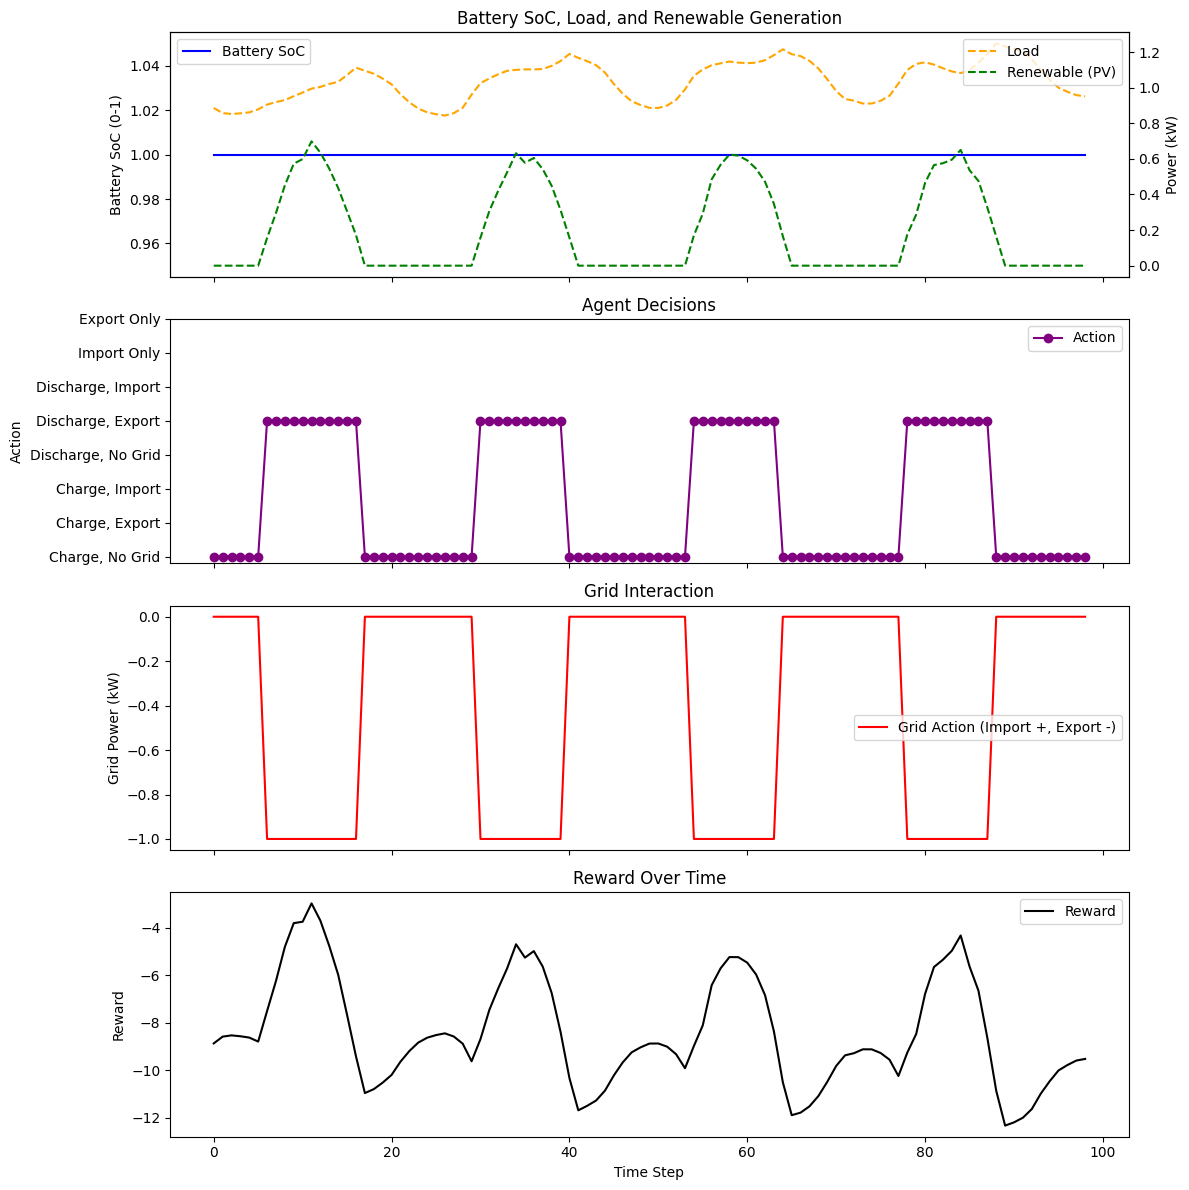

In [22]:
import numpy as np
import matplotlib.pyplot as plt
from stable_baselines3 import DQN

# Collect data over one episode
def collect_decision_data(env, model, max_steps=100):
    obs, _ = env.reset()
    states = []
    actions = []
    rewards = []

    for _ in range(max_steps):  # Limit to 100 steps for visualization
        action, _ = model.predict(obs, deterministic=True)  # Returns np.array
        action = int(action.item())  # Convert NumPy array to scalar int
        next_obs, reward, done, _, _ = env.step(action)

        # Store data
        states.append(obs)  # [soc, load, pv, import_price, export_price]
        actions.append(action)
        rewards.append(reward)

        obs = next_obs
        if done:
            break

    return np.array(states), np.array(actions), np.array(rewards)

# Run the simulation
states, actions, rewards = collect_decision_data(env, model)

# Extract grid actions (approximation post-step)
grid_actions = []
for i in range(len(actions)):
    # Map grid action based on the action taken
    if actions[i] in [2, 5, 6]:  # Grid import actions
        grid_action = env.microgrid.modules.grid.item().current_status
    elif actions[i] in [1, 4, 7]:  # Grid export actions
        grid_action = -env.microgrid.modules.grid.item().current_status
    else:  # No grid interaction (0, 3)
        grid_action = 0
    grid_actions.append(grid_action)
grid_actions = np.array(grid_actions)

# Time steps for plotting
time_steps = np.arange(len(states))

# Create the visualization
fig, (ax1, ax2, ax3, ax4) = plt.subplots(4, 1, figsize=(12, 12), sharex=True)

# Plot 1: Battery SoC and Load vs. Renewable
ax1.plot(time_steps, states[:, 0], label='Battery SoC', color='blue')
ax1.set_ylabel('Battery SoC (0-1)')
ax1.legend(loc='upper left')
ax1_twin = ax1.twinx()
ax1_twin.plot(time_steps, states[:, 1], label='Load', color='orange', linestyle='--')
ax1_twin.plot(time_steps, states[:, 2], label='Renewable (PV)', color='green', linestyle='--')
ax1_twin.set_ylabel('Power (kW)')
ax1_twin.legend(loc='upper right')
ax1.set_title('Battery SoC, Load, and Renewable Generation')

# Plot 2: Actions
ax2.plot(time_steps, actions, 'o-', label='Action', color='purple')
ax2.set_ylabel('Action')
ax2.set_yticks(range(8))
ax2.set_yticklabels([
    'Charge, No Grid',
    'Charge, Export',
    'Charge, Import',
    'Discharge, No Grid',
    'Discharge, Export',
    'Discharge, Import',
    'Import Only',
    'Export Only'
])
ax2.legend()
ax2.set_title('Agent Decisions')

# Plot 3: Grid Import/Export
ax3.plot(time_steps, grid_actions, label='Grid Action (Import +, Export -)', color='red')
ax3.set_ylabel('Grid Power (kW)')
ax3.legend()
ax3.set_title('Grid Interaction')

# Plot 4: Reward
ax4.plot(time_steps, rewards, label='Reward', color='black')
ax4.set_xlabel('Time Step')
ax4.set_ylabel('Reward')
ax4.legend()
ax4.set_title('Reward Over Time')

plt.tight_layout()
plt.show()